# Outstanding Project 3

# Sentiment analysis of tweets scraped from NDTV's Twitter handle and further classified into Positive, Neutral and Negative tweets.

## Importing all the required libraries

### Here I've used tweepy to scrape tweets from desired twitter handle. It is a library that uses Twitter's API to scrape tweets from any user's handle.

In [155]:
import tweepy
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import Cursor
from tweepy import API
from textblob import TextBlob
from wordcloud import WordCloud
import time
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
import re
import nltk
import string

from sklearn.feature_extraction.text import CountVectorizer


import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

### Here all the Keys and Token secrets are removed because those are confidential details.

In [130]:
consumer_key = 'XXXXXXXXXX'
consumer_secret = 'XXXXXXXXX'
access_token = 'XXXXXXXXXXX'
access_token_secret = 'XXXXXXXXXXX'
#authentication and connection
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth,wait_on_rate_limit=True)

In [131]:
username = 'NDTV'
count = 2000
try:     
 # Creation of query method using parameters
 tweets = tweepy.Cursor(api.user_timeline,id=username).items(count)
 
 # Pulling information from tweets iterable object
 tweets_list = [[tweet.created_at, tweet.id, tweet.text] for tweet in tweets]
 
 # Creation of dataframe from tweets list
 # Add or remove columns as you remove tweet information
 tweets_df = pd.DataFrame(tweets_list)
except BaseException as e:
      print('failed on_status,',str(e))
      time.sleep(3)

### Here is the CSV file of scraped Tweets.

In [132]:
df = tweets_df

In [133]:
df.head()

,0,1,2
0,2020-10-08 16:43:39,1314245079926620160,"Delhi's #COVID19 Tally Crosses 3 Lakh, Death C..."
1,2020-10-08 16:41:25,1314244520024760320,"Union Minister #RamVilasPaswan, Days After Hea..."
2,2020-10-08 16:36:06,1314243179248521216,.@OnReality_Check | “It is scarier if the TRPs...
3,2020-10-08 16:31:47,1314242093267578880,Top stories now on https://t.co/Fbzw6mR9Q5 \n\...
4,2020-10-08 16:30:06,1314241669194153984,#LeftRightCentre | “It has come to the fore th...


### Renaming columns to further process this data frame.

In [134]:
df = df.rename(columns={0: "Date", 1: "Tweet_id", 2: "Tweet_text" })

In [135]:
df.head()

,Date,Tweet_id,Tweet_text
0,2020-10-08 16:43:39,1314245079926620160,"Delhi's #COVID19 Tally Crosses 3 Lakh, Death C..."
1,2020-10-08 16:41:25,1314244520024760320,"Union Minister #RamVilasPaswan, Days After Hea..."
2,2020-10-08 16:36:06,1314243179248521216,.@OnReality_Check | “It is scarier if the TRPs...
3,2020-10-08 16:31:47,1314242093267578880,Top stories now on https://t.co/Fbzw6mR9Q5 \n\...
4,2020-10-08 16:30:06,1314241669194153984,#LeftRightCentre | “It has come to the fore th...


In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2000 non-null   datetime64[ns]
 1   Tweet_id    2000 non-null   int64         
 2   Tweet_text  2000 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 47.0+ KB


In [137]:
df.shape

(2000, 3)

### Dropping Unnecessary columns.

In [138]:
df = df.drop(['Date', 'Tweet_id'], axis=1)

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Tweet_text  2000 non-null   object
dtypes: object(1)
memory usage: 15.8+ KB


In [148]:
df.head()

,Tweet_text
0,"hi's COVID19 Tally Crosses 3 Lakh, Death Count..."
1,"Union Minister RamVilasPaswan, Days After Hear..."
2,.nReality_Check | “It is scarier if the TRPs a...
3,op stories now on \n\nNDTVTopStories
4,LeftRightCentre | “It has come to the fore tha...


### Cleaning the tweets containing '#', '@' and mentions. 

In [153]:
#Clean the text
#Creating a function to clean the tweets

def cleanTxt(text):
    text = re.sub(r'@[A-Za-z0-9]', '', text) #Removed @mention
    text = re.sub(r'#', '', text) #Removing '#' Mention
    text = re.sub(r'RT[\s]+', '', text) #Removing RT
    text = re.sub(r'https?:\/\/\S+', '', text) #Remove hyperlinks
    return text
#Cleaning the text
df['Tweet_text'] = df ['Tweet_text'].apply(cleanTxt)

#Showing the text
df


,Tweet_text
0,"hi's COVID19 Tally Crosses 3 Lakh, Death Count..."
1,"Union Minister RamVilasPaswan, Days After Hear..."
2,.nReality_Check | “It is scarier if the TRPs a...
3,op stories now on \n\nNDTVTopStories
4,LeftRightCentre | “It has come to the fore tha...
...,...
1995,Scientists Identify Unique Patterns In COVID19...
1996,Hathras Gang Rape Victim's Father Unhappy With...
1997,West Bengal | Congress workers staged a protes...
1998,Watch | Huge Congress protest at Yamuna Expres...


### Adding Polarity and Subjectivity to the dataset.

In [156]:
#Create to get Subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#Creating a function to get polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

#Creating two new columns in our existing database
df['Subjectivity'] = df['Tweet_text'].apply(getSubjectivity)
df['Polarity'] = df['Tweet_text'].apply(getPolarity)

#dataframe with new columns
df

,Tweet_text,Subjectivity,Polarity
0,"hi's COVID19 Tally Crosses 3 Lakh, Death Count...",0.000000,0.000000
1,"Union Minister RamVilasPaswan, Days After Hear...",0.500000,0.500000
2,.nReality_Check | “It is scarier if the TRPs a...,0.378571,-0.038095
3,op stories now on \n\nNDTVTopStories,0.000000,0.000000
4,LeftRightCentre | “It has come to the fore tha...,0.000000,0.000000
...,...,...,...
1995,Scientists Identify Unique Patterns In COVID19...,1.000000,0.375000
1996,Hathras Gang Rape Victim's Father Unhappy With...,0.350000,-0.158333
1997,West Bengal | Congress workers staged a protes...,0.050000,-0.075000
1998,Watch | Huge Congress protest at Yamuna Expres...,0.900000,0.400000


### Plotting a Word Cloud to check the most used word.

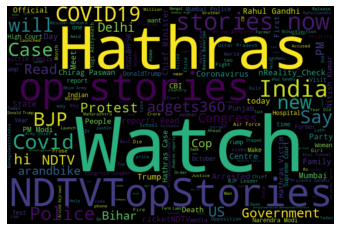

In [161]:
#Plotting the word cloud 
allWords = ' '.join( [twts for twts in df['Tweet_text']] )
wordCloud = WordCloud(width = 750, height = 500, random_state = 21, max_font_size = 175).generate(allWords)

plt.imshow(wordCloud, Interpolation = "bilinear")
plt.axis('off')
plt.show()

### Computing different types of sentiment.

In [166]:
#Create a function to compute negative, neutral and positive
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
    
df['Analysis'] = df['Polarity'].apply(getAnalysis)

In [167]:
df

,Tweet_text,Subjectivity,Polarity,Analysis
0,"hi's COVID19 Tally Crosses 3 Lakh, Death Count...",0.000000,0.000000,Neutral
1,"Union Minister RamVilasPaswan, Days After Hear...",0.500000,0.500000,Positive
2,.nReality_Check | “It is scarier if the TRPs a...,0.378571,-0.038095,Negative
3,op stories now on \n\nNDTVTopStories,0.000000,0.000000,Neutral
4,LeftRightCentre | “It has come to the fore tha...,0.000000,0.000000,Neutral
...,...,...,...,...
1995,Scientists Identify Unique Patterns In COVID19...,1.000000,0.375000,Positive
1996,Hathras Gang Rape Victim's Father Unhappy With...,0.350000,-0.158333,Negative
1997,West Bengal | Congress workers staged a protes...,0.050000,-0.075000,Negative
1998,Watch | Huge Congress protest at Yamuna Expres...,0.900000,0.400000,Positive


### Plotting Scatter plot.

Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'Subjectivity')

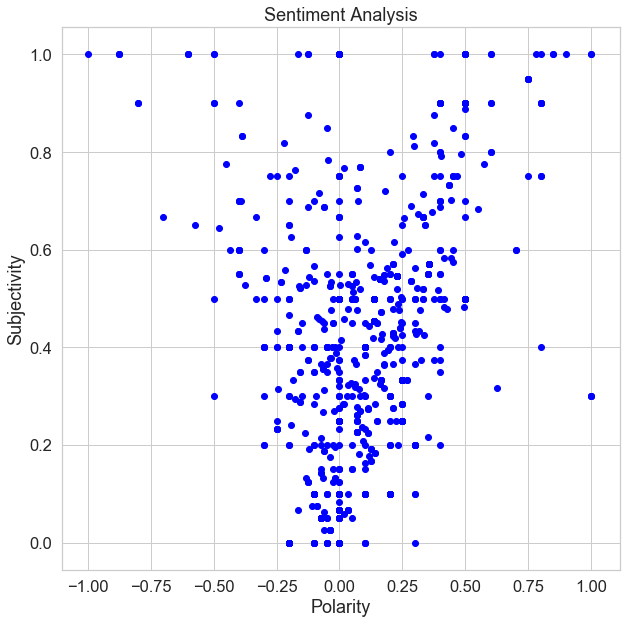

In [176]:
#Plotting the scatter plot of Subjectivity and Polarity
%pylab inline
plt.figure(figsize(10,10))
for i in range(0, df.shape[0]):
    plt.scatter(df['Polarity'][i], df['Subjectivity'][i], color='Blue')
    
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')


### Calculating percentage of different types of tweets.

In [177]:
#getting percentage of positive tweets 
ptweets = df[df.Analysis == 'Positive']
ptweets = ptweets['Tweet_text']
round((ptweets.shape[0]/df.shape[0])*100,1)

28.1

In [178]:
#getting percentage of negative tweets 
ntweets = df[df.Analysis == 'Negative']
ntweets = ntweets['Tweet_text']
round((ntweets.shape[0]/df.shape[0])*100,1)

14.4

In [179]:
#getting percentage of neutral tweets 
neutral_tweets = df[df.Analysis == 'Neutral']
neutral_tweets = neutral_tweets['Tweet_text']
round((neutral_tweets.shape[0]/df.shape[0])*100,1)

57.4

### Plotting Bar Graph for the result.

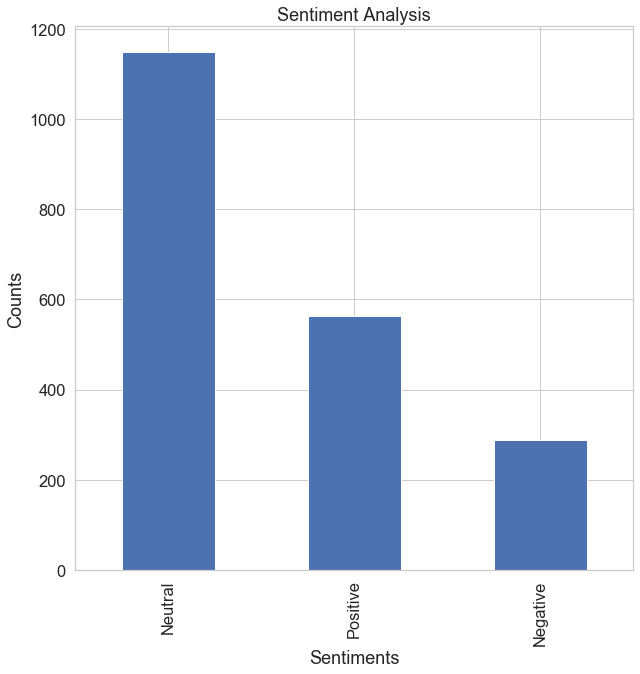

In [181]:
#Show the value counts 
df['Analysis'].value_counts()

#Visualising the result
plt.title('Sentiment Analysis')
plt.xlabel('Sentiments')
plt.ylabel('Counts')

df['Analysis'].value_counts().plot(kind = 'bar')
plt.show()